## Exploration of the Estonian - Latvian Dataset

In [1]:
# General Imports
library(tidyverse)

library(divermeta)
library(vegan)
library(ggplot2)
library(repr)  # For resizing plot in Jupyter Notebook
library(latex2exp)
library(Matrix)
library(tools)
library(tidyverse)
library(dplyr)
library(tibble)
library(permuco)
library(marginaleffects)
library(writexl)
library(ggh4x)
library(patchwork)
library(grid) # for textGrob
library(cowplot)
library(igraph)

source("utils/general_functions.R")


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: permute


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘igraph’


The following object is masked from ‘package:marginaleffects’:

    components


The following object is masked from ‘

## Distance Based Multiplicity

In [2]:
data  <- qs::qread("EST-LAT/vegetation.qs")

In [3]:
df_vegetation  <- data$metaveg
head(df_vegetation)

SampleID,vegetation_type
<chr>,<chr>
S208,forest
S227,forest
S678,forest
S480,forest
EE14,forest
S475,forest


In [4]:
# Reads
abundance_file <- "EST-LAT/EstLat_Veg-DenoisedTable.txt"
df_abbundance  <- read_tsv(abundance_file, col_types = cols())

head(df_abbundance)

ID_Clustered,ID_Denoised,EE11,EE14,G2767,G2819,G2830,G2847,G3449,G3518,⋯,S554,S557,S558,S579,S581,S589,S675,S678,S684,s508
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
00162b030fcce9f3eb5ff75f5dc59030011424b6,00162b030fcce9f3eb5ff75f5dc59030011424b6,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
00162b030fcce9f3eb5ff75f5dc59030011424b6,136ef4e86fce021b0c47bf1e9a8c812a1037e880,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
00162b030fcce9f3eb5ff75f5dc59030011424b6,3ac6bdd6450091c7220da89616ef0477732a6b8b,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
00162b030fcce9f3eb5ff75f5dc59030011424b6,49074181339a6c8a1f8531c6b02d9706f411c4ea,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
00162b030fcce9f3eb5ff75f5dc59030011424b6,771d7cdd9b7bd4c53f8a74d698f3e8ac17c87506,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
00162b030fcce9f3eb5ff75f5dc59030011424b6,d0a0d5ba9e58e7bab7cfb518d60803959c79bf17,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [5]:
# Generates the files
diss_file <- "EST-LAT/EstLat_SeqDistances/unified_distances.csv"
diss_clust_file <- "EST-LAT/EstLat_SeqDistances/unified_distances_clusters.csv"


#  Wites the empty headers
base_tibble  <- tibble(ID1 = character(), ID2 = character(), Distance = numeric())
write.table(base_tibble, file = diss_file, sep = ",", row.names = FALSE, col.names = TRUE)
write.table(base_tibble, file = diss_clust_file, sep = ",", row.names = FALSE, col.names = TRUE)

In [6]:
# Unifies distances

base_clusters <- df_abbundance %>% 
        select(ID_Clustered, ID_Denoised)

clusts_ids  <- unique(base_clusters$ID_Clustered)


# Iterates over each of the clusters to construct further clusters
dfs  <- list()

i <- 0
total_clust <- length(unique(base_clusters$ID_Clustered))

# Saves the inner distances
for (base_clust_id in clusts_ids) {

    i <-  i +1
    # print(paste(base_clust_id, i,"of", total_clust, sep = " "))
    flush.console()

    # Extract the current ids
    df_ids <- base_clusters %>% 
        filter(ID_Clustered == base_clust_id) %>% 
        select(ID_Denoised) %>% 
        distinct()

    num_ids <- nrow(df_ids)
    # print(num_ids)

    if(num_ids == 1)
    {
        dfs[[base_clust_id]]  <- data.frame(ID1 = df_ids$ID_Denoised, ID2 = df_ids$ID_Denoised, Distance = 0)
        next
    }


    # Loads the distance file
    dist_file <- paste("EST-LAT/EstLat_SeqDistances/Split_OTUs_Distances/",base_clust_id,".txt", sep="")
    df_dist  <- read_tsv(dist_file, col_types = cols(), col_names = c("ID1", "ID2", "Distance"))

    df_dist <- df_dist %>% 
    filter(ID1 %in% df_ids$ID_Denoised & ID2 %in% df_ids$ID_Denoised)

    dfs[[base_clust_id]]  <- df_dist
}

dfs_distances <- bind_rows(dfs)

#  Saves
write_csv(dfs_distances, diss_file, append = TRUE, col_names = FALSE)


## Main Funciton
Funciton for computing the values of multiplicity and diversity

In [7]:

constructClusterMap <- function(base_clusters, clust_distances)
{

      total_clust <- length(unique(base_clusters$ID_Clustered)) # Total Clusters

      # Iterates over each of the clusters to construct further clusters
      # Assumes that different clusters have a distance above the max used distance
      dfs  <- list()

      # Max Cutoff to optimize multipliity computation
      max_cut_off <- NULL

      i <- 0 # Iterations
      # Computes the different clusters
      base_cluster_ids <- unique(base_clusters$ID_Clustered)      
      for (base_clust_id in base_cluster_ids) {

          i <- i +1
          print(paste("   ",base_clust_id, i,"of", total_clust, sep = " "))
          flush.console()

          # Extract the current ids
          df_ids <- base_clusters %>% 
            filter(ID_Clustered == base_clust_id) %>% 
            select(ID_Denoised) %>% 
            distinct()

          num_ids <- nrow(df_ids)
          
          # Case where there is only one element inside the cluster
          if(num_ids == 1)
          {
            df_map  <- data.frame(ID_Denoised = df_ids$ID_Denoised)
            
            # Builds the mapping for all cluster distance, in this case each column is the same
            for(clust_dist in clust_distances)        
                  df_map[[paste("Cluster",clust_dist, sep= "_")]] <- paste(base_clust_id, 1, sep = "_")
            
            df_map[["ID_Clustered"]] <- base_clust_id

            dfs[[base_clust_id]]  <- df_map            

            next
          }

          # Case where there is more than one element inside the cluster

          # Loads the distance file
          dist_file <- paste("EST-LAT/EstLat_SeqDistances/Split_OTUs_Distances/",base_clust_id,".txt", sep="")
          df_dist  <- read_tsv(dist_file, col_types = cols(), col_names = c("ID1", "ID2", "Distance"))

          # Filters so that no ghost ids are present
          df_dist <- df_dist %>% 
            filter(ID1 %in% df_ids$ID_Denoised & ID2 %in% df_ids$ID_Denoised)



          # Computes the single linkage clustering via the connected components of an indirected graph
          # For each one of the cluster distances
          df_map_joined <- NULL
          df_resp <- NULL

          # Computes Cutoff
          max_dist <- max(df_dist$Distance)
          
          cut_off <- max(clust_distances)
          if(max_dist < max(clust_distances))
              cut_off <- clust_distances[which(clust_distances >  max_dist)[1]]


          for(clust_dist in clust_distances)
          {
              if(clust_dist > cut_off && !is.null(df_resp))
              {
                df_map  <- df_resp
                df_map[[paste("Cluster",clust_dist, sep= "_")]] <- final_ids
                df_map_joined <- df_map_joined %>% left_join(df_map, by = "ID_Denoised")                
                next
              }
                
              node_ids <- df_ids$ID_Denoised
              edges <- df_dist %>% 
                filter(Distance <= clust_dist) %>% 
                select(ID1, ID2) %>% 
                filter(ID1 != ID2) %>% 
                mutate(ID1 = as.character(ID1), ID2 = as.character(ID2))

              # Create a graph from the tibble, ensuring all nodes are included
              g <- graph_from_data_frame(edges, directed = FALSE, vertices = node_ids)

              # Find the connected components
              components_result <- components(g)

              # Gets the final cluster ids
              final_ids <- as.vector(sapply(components_result$membership, function(s) {return(paste(base_clust_id, s, sep = "_"))}))
              
              # Saves response
              df_resp  <- data.frame( ID_Denoised = names(components_result$membership))
              
              df_map  <- df_resp
              df_map[[paste("Cluster",clust_dist, sep= "_")]] <- final_ids

              if(is.null(df_map_joined))
              {
                df_map_joined <- df_map
              } else {
                df_map_joined <- df_map_joined %>% left_join(df_map, by = "ID_Denoised")
              }
          }

          df_map_joined[["ID_Clustered"]] <- base_clust_id
                              
          dfs[[base_clust_id]]  <- df_map_joined

          # Updates the max cutoff
          if(is.null(max_cut_off))
            max_cut_off <- cut_off

          max_cut_off <- max(max_cut_off, cut_off)

        }

      df_final_mapping <- bind_rows(dfs)
      return(df_final_mapping)

}


computeValues <- function(sampleID, df_global_mapping, df_abbundance, cluster_ids = NA, clust_distances = seq(from = 0, to = 0.03, by = 0.002))
{


      # Sets the sample structure
      df_sample <- df_abbundance %>% 
        select(ID_Denoised, all_of(sampleID))

      df_sample[["Abundance"]] <- df_sample[[sampleID]]
      df_sample <- df_sample %>% select(ID_Denoised, Abundance)      
      
      # # Support function           
      df_mapping <- df_global_mapping

      # If cluster ids are provided, filters out
      if(!is.null(cluster_ids))      
        df_mapping <- df_mapping %>% filter(ID_Clustered %in% cluster_ids)
      

      df_mapping <- df_mapping %>% 
        left_join(df_sample, by = "ID_Denoised") %>% 
        filter(Abundance > 0)



      diversities <- c()
      multiplicities <- c()

      m <- NULL
      d <- NULL
      for(clust_dist in clust_distances){

        # if(clust_dist > max(df_dist$Distance) && !is.null(d) && !is.null(m))
        # {
        #     diversities <- c(diversities, d)
        #     multiplicities <- c(multiplicities, m)
        #     next
        # }
        
        col_name <- paste("Cluster",clust_dist, sep= "_")

        df_clustered <- df_mapping %>% 
          select(all_of(col_name), Abundance)  %>% 
            group_by(!!sym(col_name)) %>% 
            summarise(Abundance = sum(Abundance)) %>% 
            arrange(desc(Abundance))


            m <- multiplicity.inventory(df_mapping$Abundance, df_mapping[[col_name]])
            
          if(length(df_clustered$Abundance) == 0)
            d <- 0
          else 
             d <- renyi(df_clustered$Abundance, hill = TRUE, scales = 1)[[1]]

            diversities <- c(diversities, d)
            multiplicities <- c(multiplicities, m)

      }

      final_data_frame <- data.frame(Clust_Dist = clust_distances, Diversity = diversities, Multiplicity = multiplicities)
      return(final_data_frame)
}

# df <- computeValues(sampleID)



## Vegetation

In [8]:
# qs::qload("EST-LAT/vegetation.qs")
#qs::qreadm("EST-LAT/biome.qs")
data  <- qs::qread("EST-LAT/vegetation.qs")


In [9]:
df_vegetation  <- data$metaveg 

In [10]:
included_vegetation <- c('forest', 'park', 'energy plantation')

table(df_vegetation$vegetation_type)


            alley energy plantation            forest              park 
               14                23                25                25 
            ruins          woodland 
               25                25 

In [11]:
# Reads
abundance_file <- "EST-LAT/EstLat_Veg-DenoisedTable.txt"
df_abbundance  <- read_tsv(abundance_file, col_types = cols())

head(df_abbundance)

ID_Clustered,ID_Denoised,EE11,EE14,G2767,G2819,G2830,G2847,G3449,G3518,⋯,S554,S557,S558,S579,S581,S589,S675,S678,S684,s508
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
00162b030fcce9f3eb5ff75f5dc59030011424b6,00162b030fcce9f3eb5ff75f5dc59030011424b6,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
00162b030fcce9f3eb5ff75f5dc59030011424b6,136ef4e86fce021b0c47bf1e9a8c812a1037e880,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
00162b030fcce9f3eb5ff75f5dc59030011424b6,3ac6bdd6450091c7220da89616ef0477732a6b8b,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
00162b030fcce9f3eb5ff75f5dc59030011424b6,49074181339a6c8a1f8531c6b02d9706f411c4ea,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
00162b030fcce9f3eb5ff75f5dc59030011424b6,771d7cdd9b7bd4c53f8a74d698f3e8ac17c87506,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
00162b030fcce9f3eb5ff75f5dc59030011424b6,d0a0d5ba9e58e7bab7cfb518d60803959c79bf17,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [12]:

min_count <- 15
taxa_level <- "Genus"
print(taxa_level)

cols <- c('QueryName','Order','Family','Genus','Species')

df_taxa <- data$taxveg %>% select(all_of(cols)) %>% dplyr::rename(ID_Clustered = QueryName)

totals <- table(df_taxa[[taxa_level]])
df_order <- tibble(Taxa = names(totals), Count = as.vector(totals))
df_order <- df_order %>% arrange(-Count)

print(paste("Total Groups: ", nrow((df_order))))

selected_genus <- c(
"Cenococcum",
"Cortinarius",
"Russula",
"Sebacina" ,
"Hebeloma",
"Tuber"
)

df_order <- df_order %>% filter(Taxa %in% selected_genus )

print(paste("Total Groups Selected Groups: ", nrow((df_order))))


df_order

[1] "Genus"
[1] "Total Groups:  81"
[1] "Total Groups Selected Groups:  6"


Taxa,Count
<chr>,<int>
Cortinarius,237
Russula,164
Sebacina,133
Hebeloma,39
Tuber,26
Cenococcum,21


In [13]:
clust_distances  <- seq(from = 0, to = 0.045, by = 0.002)


# Precomputes the mapping cluster by cluster distance
# Gets the df for the list of clusters
base_clusters <- df_abbundance %>% 
  select(ID_Clustered, ID_Denoised)

# External Function 
df_final_mapping <- constructClusterMap(base_clusters, clust_distances)  


[1] "    00162b030fcce9f3eb5ff75f5dc59030011424b6 1 of 2127"
[1] "    0017df88c450e53ddfc2ddb9cf6a3da7360d20c4 2 of 2127"
[1] "    002506456c54dae873b3f38a675bb3dec6e7b1aa 3 of 2127"
[1] "    002b1cc861fd5cfa4d89a3e971fa8a9edc2e9cba 4 of 2127"
[1] "    00440cbbc4974cef9f2b0a73630c534185b492cf 5 of 2127"
[1] "    00616b1001ce77c61a318640cfc60bf2e84583ef 6 of 2127"
[1] "    0078bdf06ec20db95ad4d4742e2eb8a0f5a3ca3f 7 of 2127"
[1] "    009ddfa52e3b4a0948b8d781f9713e2c02ecb2a2 8 of 2127"
[1] "    00ab5a912bb90e0f8cf59839996788ab152df84b 9 of 2127"
[1] "    00cbd68afdb0d9bac98facd23ec63b7dfde74441 10 of 2127"
[1] "    00d05b900a4b3876e72ff23d4da42aea1ee33cf0 11 of 2127"
[1] "    00fae35bd83e68db671014e4c2e5ad987334c02e 12 of 2127"
[1] "    00fafd06840fc71b7690346c4df21e4d3b2f4474 13 of 2127"
[1] "    011299592155f117564bf104de762e6a696d39ac 14 of 2127"
[1] "    0123d0493f4f32d8b77c7c78db80c88c6f55e4eb 15 of 2127"
[1] "    0178a05dbc1421961d77c83a514cf84b4e14d170 16 of 2127"
[1] "    01884c20

In [14]:
sample_ids <- colnames(df_abbundance  %>% select(-ID_Denoised,-ID_Clustered))

file_name <- "EST-LAT/processed_data/multi_diver_veg.csv"

# Loads the already processed data
df_done <- read_csv(file_name, col_types = cols())

sample_ids <- setdiff(sample_ids, df_done$SampleID)

print(length(sample_ids))

i <- 0

 
for(sampleID in sample_ids)
{
  i  <- i + 1
  print(paste(sampleID, i, "of", length(sample_ids), sep = " "))
  flush.console()

  # Extract the vegetation
  vegetation <- df_vegetation %>% filter(SampleID == sampleID) %>% pull(vegetation_type)

  if(!(vegetation %in% included_vegetation))
    next

  
    sample_cluster_ids <- df_abbundance %>% filter(!!sym(sampleID) > 0) %>% select(ID_Clustered) %>% distinct() %>% pull(ID_Clustered)

    # First By taxa
    for(txg in df_order$Taxa)
    {

        print(paste0("   ", txg))
        flush.console()
        
        cluster_ids <- df_taxa %>% filter(!!sym(taxa_level) == txg) %>% pull(ID_Clustered)
                
        df <- computeValues(sampleID, df_final_mapping, df_abbundance, cluster_ids, clust_distances)
        df[["Cross"]] <- df[["Diversity"]] * df[["Multiplicity"]]
        df[["sampleID"]] <- sampleID
        df[["Taxa"]] <- txg
        df[["Vegetation"]] <- vegetation
        df[["Plateau"]] <- clust_distances[which.min(df[["Diversity"]])]

        
        df <- df %>% 
          select(Vegetation, Taxa, sampleID, Clust_Dist, Diversity, Multiplicity, Cross, Plateau)

          write.table(df, file = file_name, sep = ",", row.names = FALSE, col.names = FALSE, append = TRUE)

    }

    print(paste0("   ", "All"))
    flush.console()
        

    # Lastly for all of them
    df <- computeValues(sampleID, df_final_mapping, df_abbundance, NULL, clust_distances)
    df[["Cross"]] <- df[["Diversity"]] * df[["Multiplicity"]]
    df[["sampleID"]] <- sampleID
    df[["Taxa"]] <- "All"
    df[["Vegetation"]] <- vegetation
    df[["Plateau"]] <- clust_distances[which.min(df[["Diversity"]])]

    df <- df %>% 
      select(Vegetation, Taxa, sampleID, Clust_Dist, Diversity, Multiplicity, Cross, Plateau)

    write.table(df, file = file_name, sep = ",", row.names = FALSE, col.names = FALSE, append = TRUE)


}


# Now it goes by vegetation but all samples


df_abbundance_by_vegetation <- df_abbundance %>% select(ID_Denoised, ID_Clustered)

for(veg in included_vegetation)
{
    veg_samples <- df_vegetation %>% filter(vegetation_type == veg) %>% pull(SampleID)   
    df_abbundance_by_vegetation[[veg]] <- rowSums(df_abbundance %>% select(all_of(veg_samples)))
}


# Commputes
for(veg in included_vegetation)
{
    print(veg)
    flush.console()

      veg_cluster_ids <- df_abbundance_by_vegetation %>% filter(!!sym(veg) > 0) %>% select(ID_Clustered) %>% distinct() %>% pull(ID_Clustered)


      # First By taxa
      for(txg in df_order$Taxa)
      {

          print(paste0("   ", txg))
          flush.console()
          
          cluster_ids <- df_taxa %>% filter(!!sym(taxa_level) == txg) %>% pull(ID_Clustered)
                  
          df <- computeValues(veg, df_final_mapping, df_abbundance_by_vegetation, cluster_ids, clust_distances)
          df[["Cross"]] <- df[["Diversity"]] * df[["Multiplicity"]]
          df[["sampleID"]] <- "All"
          df[["Taxa"]] <- txg
          df[["Vegetation"]] <- veg
          
          df[["Plateau"]] <- clust_distances[which.min(df[["Diversity"]])]



          df <- df %>% 
            select(Vegetation, Taxa, sampleID, Clust_Dist, Diversity, Multiplicity, Cross, Plateau)

            write.table(df, file = file_name, sep = ",", row.names = FALSE, col.names = FALSE, append = TRUE)

      }

      print(paste0("   ", "All"))
      flush.console()
          

      # Lastly for all of them
      df <- computeValues(veg, df_final_mapping, df_abbundance_by_vegetation, NULL, clust_distances)
      df[["Cross"]] <- df[["Diversity"]] * df[["Multiplicity"]]
      df[["sampleID"]] <- "All"
      df[["Taxa"]] <- "All"
      df[["Vegetation"]] <- veg
      df[["Plateau"]] <- clust_distances[which.min(df[["Diversity"]])]




      df <- df %>% 
        select(Vegetation, Taxa, sampleID, Clust_Dist, Diversity, Multiplicity, Cross, Plateau)

      write.table(df, file = file_name, sep = ",", row.names = FALSE, col.names = FALSE, append = TRUE)


}




print("Done")


[1] 64
[1] "G2767 1 of 64"
[1] "G2819 2 of 64"
[1] "G2830 3 of 64"
[1] "G4097 4 of 64"
[1] "G4101 5 of 64"
[1] "G4103 6 of 64"
[1] "G4164 7 of 64"
[1] "G4169 8 of 64"
[1] "G4175 9 of 64"
[1] "G4195 10 of 64"
[1] "G4200 11 of 64"
[1] "G4214 12 of 64"
[1] "G4223 13 of 64"
[1] "G4242 14 of 64"
[1] "G4247 15 of 64"
[1] "G4275 16 of 64"
[1] "G4276 17 of 64"
[1] "G4279 18 of 64"
[1] "G4280 19 of 64"
[1] "G4283 20 of 64"
[1] "G4310 21 of 64"
[1] "G4311 22 of 64"
[1] "G4343 23 of 64"
[1] "G4375 24 of 64"
[1] "G4377 25 of 64"
[1] "G4379 26 of 64"
[1] "G4383 27 of 64"
[1] "G4403 28 of 64"
[1] "G4434 29 of 64"
[1] "G4435 30 of 64"
[1] "G4465 31 of 64"
[1] "G4495 32 of 64"
[1] "G4505 33 of 64"
[1] "G4513 34 of 64"
[1] "G4514 35 of 64"
[1] "G4615 36 of 64"
[1] "G4619 37 of 64"
[1] "G4622 38 of 64"
[1] "G4625 39 of 64"
[1] "G4631 40 of 64"
[1] "G4644 41 of 64"
[1] "G4690 42 of 64"
[1] "G4724 43 of 64"
[1] "G4730 44 of 64"
[1] "G4735 45 of 64"
[1] "G4740 46 of 64"
[1] "G4745 47 of 64"
[1] "G4748 48 o

## Plateau

In [15]:
file_name <- "EST-LAT/processed_data/multi_diver_veg.csv"
df <- read_csv(file_name, col_types = cols())    

df_analysis <- df %>%      
        filter(Taxa != "All")  %>% 
        filter(Diversity > 0 ) %>% 
        filter(SampleID != "All") %>% 
        select(Vegetation, Taxa, SampleID, Plateau)  %>% 
        distinct()
   

In [16]:

tests_resp <- single_kw_and_dunn_test(df_test = df_analysis,
                        order = selected_genus,
                        labels= selected_genus,
                        value_col = "Plateau",
                        group_col = "Taxa",
                        value_name = "Plateau",
                        group_name = "Genus",                             
                        kw_caption = "Kruskal-Wallis test results for $\\sigma$ value at which ($^1D$) and distance-based multiplicity ($\\delta M_{0.02}$) plateau comparing the different taxa.",
                        dun_caption = "Dunn's test results for $\\sigma$ value at which ($^1D$) and distance-based multiplicity ($\\delta M_{0.02}$) plateau comparing the different taxa.",
                        kw_label = "tab:kw_plateau_baltics",
                        dunn_label= "tab:dunn_plateau_baltics")


cld <- compute_cld(dunn_result = tests_resp$dunn_val, short_label_order = selected_genus, label_order = selected_genus)

cat(tests_resp$kw_table)
cat("\n\n\n\n")
cat(tests_resp$dunn_table)


\begin{table}[!h]
\centering
\caption{Kruskal-Wallis test results for $\sigma$ value at which ($^1D$) and distance-based multiplicity ($\delta M_{0.02}$) plateau comparing the different taxa.}
\centering
\begin{tabular}[t]{llrrl}
\toprule
  & Metric & $\chi^2$ & df & p-val\\
\midrule
Kruskal-Wallis chi-squared & Plateau & 48.4091 & 5 & 0.0001 ***\\
\bottomrule
\end{tabular}
\label{tab:kw_plateau_baltics}
\end{table}



\begin{table}[!h]
\centering
\caption{Dunn's test results for $\sigma$ value at which ($^1D$) and distance-based multiplicity ($\delta M_{0.02}$) plateau comparing the different taxa.}
\centering
\begin{tabular}[t]{llll}
\toprule
\multicolumn{1}{c}{ } & \multicolumn{3}{c}{Plateau} \\
\cmidrule(l{3pt}r{3pt}){2-4}
Comparison & Z & p-val (unadj) & p-val (adj)\\
\midrule
Cenococcum - Cortinarius & -0.6384 & 0.5232 & 0.5606\\
Cenococcum - Hebeloma & 2.6160 & 0.0089 ** & 0.0191 *\\
Cortinarius - Hebeloma & 3.5592 & 0.0004 *** & 0.0009 ***\\
Cenococcum - Russula & -1.2439 & 0.2

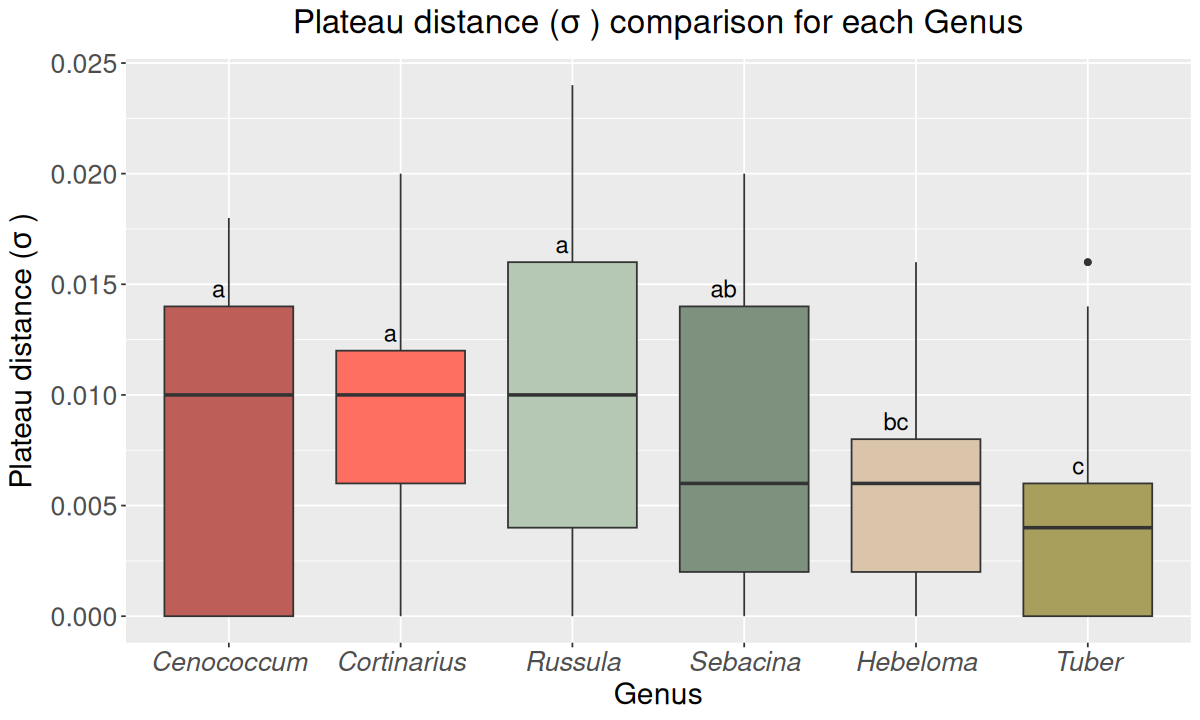

In [17]:
df_plot <- df_analysis


label_order  <- selected_genus
df_plot <- df_plot %>% rename(Group = Taxa)

 df_plot <- df_plot %>%
      mutate(Group := factor(Group, levels = label_order))

custom_colors <- c(
  "#BE5E58",
  "#FF6F61",
  "#B4C8B4",
  "#7D917E",
  # "#5A7273",
  # "#6A8D9A",
   "#DAC5AA",
  "#A89F5D"
)


plaeau_col <- "Plateau"
group_col <- "Taxa"

plateau_name <- TeX("Plateau distance ($\\sigma$ )")
group_name <- "Vegetation Type"

title <- TeX("Plateau distance ($\\sigma$ ) comparison for each Genus")



# Compact Letter Display
cld_positions <- df_plot %>%
  group_by(Group) %>%
  summarize(y_pos = quantile(Plateau, 0.75)) # Get the max y-value for each Group

cld_positions$labels <- cld$Letters[cld_positions$Group]

p <- ggplot(df_plot, aes(x = Group, y = Plateau, fill = Group)) +
    geom_boxplot() +
    labs(
      title = title,
      x = "Genus",
      y = plateau_name
    ) + # Compact Letter displays
    geom_text(
      data = cld_positions,
      aes(x = Group, y = y_pos, label = labels),
       hjust = 1.3 ,# Shifts to the left
      vjust = -0.5,
      size = 5, # Adjust text size
      inherit.aes = FALSE
    ) +
    scale_x_discrete(labels = selected_genus) +
    scale_fill_manual(values = custom_colors) + # Add labels
    theme(
      axis.title = element_text(size = 18), # Increase axis title font size
      axis.text = element_text(size = 16), # Increase axis label font size
      plot.title = element_text(size = 20, hjust = 0.5),
      axis.text.x = element_text(face = "italic"),  # <-- italic x-axis labels      
    ) + theme(legend.position = "none")



  # Save combined plot
  ggsave(
    paste0("EST-LAT/results/plateau_plot_baltics.png"),
    plot = p,
    width = 12, height = 6, dpi = 400, bg = "white"
  )


  options(repr.plot.width = 10, repr.plot.height = 6)

p

## Sigma Select

In [ ]:
# file_name <- "EST-LAT/processed_data/multi_diver_veg.csv"

# spread <- 0.2

# df_plot <- df_analysis %>% 
#     filter(Diversity>0)  %>% 
#     group_by(Vegetation, Taxa, Clust_Dist)  %>% 
#     summarise(Diversity_mean = quantile(Diversity, 0.5), Diversity_min = quantile(Diversity, 0.5 - spread/2), Diversity_max = quantile(Diversity, 0.5 + spread/2),
#               Multiplicity_mean = quantile(Multiplicity, 0.5), Multiplicity_min = quantile(Multiplicity, 0.5 - spread/2), Multiplicity_max = quantile(Multiplicity, 0.5 + spread/2),
#               Cross_mean = quantile(Cross, 0.5), Cross_min = quantile(Cross, 0.5 - spread/2), Cross_max = quantile(Cross, 0.5 + spread/2))


# for(txg in df_order$Taxa)
# {

#   options(repr.plot.width = 22, repr.plot.height = 8)

#   selected_taxa <- txg

#   # Define vegetation order and colors
#   veg_levels <- c('forest', 'park', 'energy plantation')

#     custom_colors <- c('#7D917E',
#                     '#DAC5AA',
#                     '#BE5E58'
#       )

#   # Load processed data
#   df <- df_plot %>% filter(Taxa == txg)
#   df <- df %>% mutate(Vegetation = factor(Vegetation, levels = veg_levels))

#   # Common plot style function
#   make_plot <- function(y_var, y_label, show_legend = TRUE, show_x_label = FALSE) {
#     ggplot(df, aes(x = Clust_Dist, y = .data[[paste0(y_var, "_mean")]], fill = Vegetation, color = Vegetation)) +
#         geom_ribbon(aes(ymin = .data[[paste0(y_var, "_min")]], ymax = .data[[paste0(y_var, "_max")]]), alpha = 0.1) +
#         geom_line(linewidth = 2) +
#         scale_color_manual(values = custom_colors) +   # apply custom colors
#         scale_fill_manual(values = custom_colors) +   # apply custom colors
#           labs(
#           x = if (show_x_label) TeX("Cluster Cutoff Distance ($\\sigma \\;$)") else NULL,
#           y = TeX(y_label),
#           color = "Habitat Type"
#         ) +
#         theme_minimal() +
#         theme(
#           plot.margin = margin(2, 2, 2, 2, "cm"),
#           axis.title = element_text(size = 22),
#           axis.text = element_text(size = 18),
#           legend.title = element_text(size = 18),
#           legend.text = element_text(size = 16),
#           axis.title.x = element_text(vjust = -0.5),
#           legend.position = if (show_legend) "right" else "none"
#         )
#   }

#   # Create plots
#   p1 <- make_plot("Diversity", "$^1D$", show_legend = FALSE)
#   p2 <- make_plot("Multiplicity", "$^1M$", show_legend = FALSE, show_x_label = TRUE)
#   p3 <- make_plot("Cross", "$^1D X ^1M$", show_legend = TRUE)

#   # Combine into single row
#   final_plot <- p1 + p2 + p3 +
#     plot_layout(ncol = 3, guides = "collect") &
#     theme(plot.margin = margin(0.5, 1, 0.5, 1, "cm"))

#   # Add tags A, B, C + global title
#   final_plot <- final_plot + 
#     plot_annotation(
#       title = TeX(paste0("Diversity Metrics vs Cluster Cutoff Distance (", selected_taxa, ")")),
#       tag_levels = 'A'
#     ) &
#     theme(
#       plot.tag = element_text(face = "bold", size = 22),
#       plot.title = element_text(size = 26, hjust = 0.5, margin = margin(b = 40))
#     )

#   # Save combined plot
#   # ggsave(
#   #   paste0("EST-LAT/results/sigma_plots/", tolower(txg), "_all_samples_three_metrics.png"),
#   #   plot = final_plot,
#   #   width = 22, height = 10, dpi = 400, bg = "white"
#   # )

#   print(final_plot)

# }

ERROR: [1m[33mError[39m in `filter()`:[22m
[1m[22m[36mℹ[39m In argument: `Diversity > 0`.
[1mCaused by error:[22m
[33m![39m object 'Diversity' not found


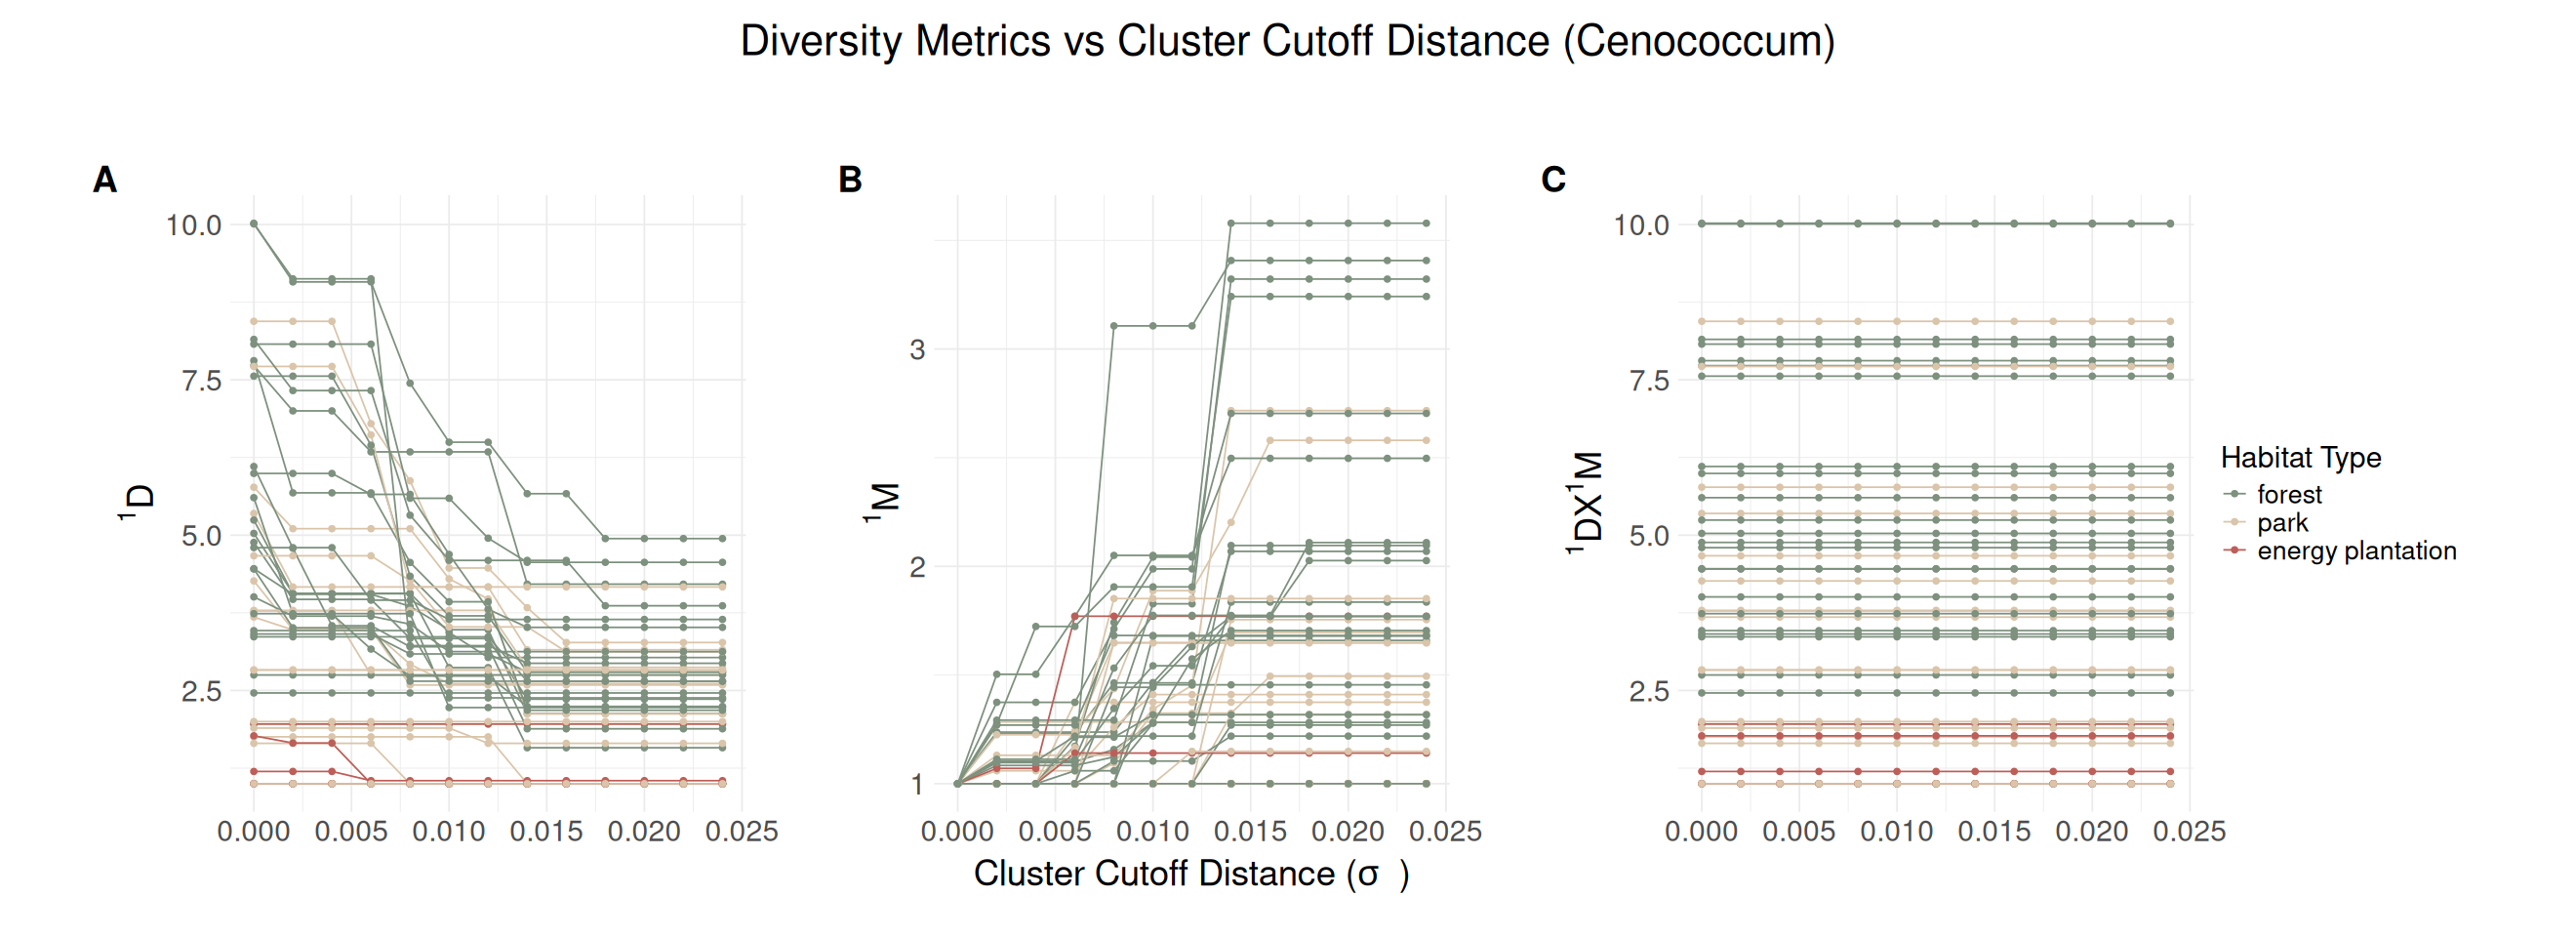

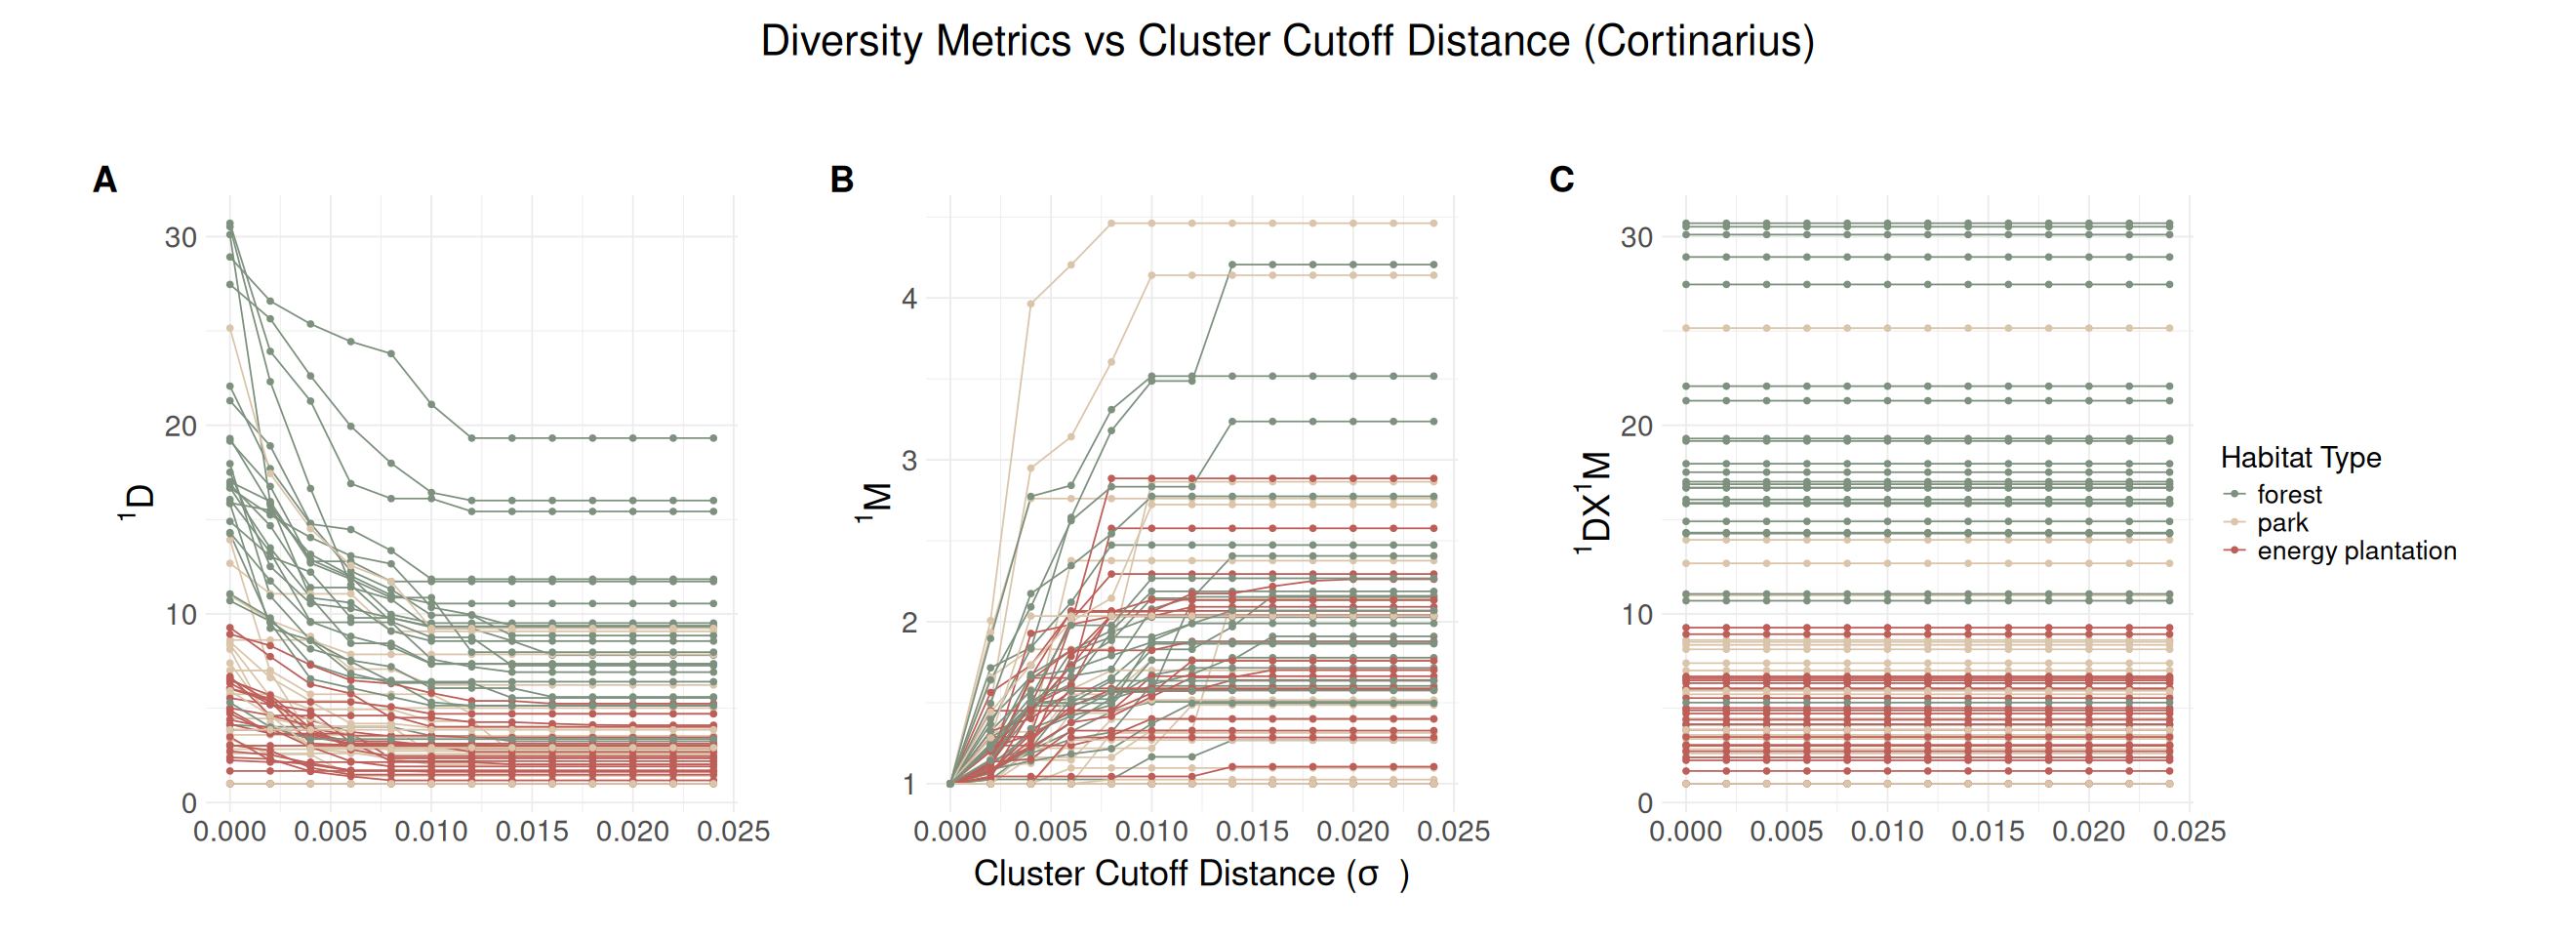

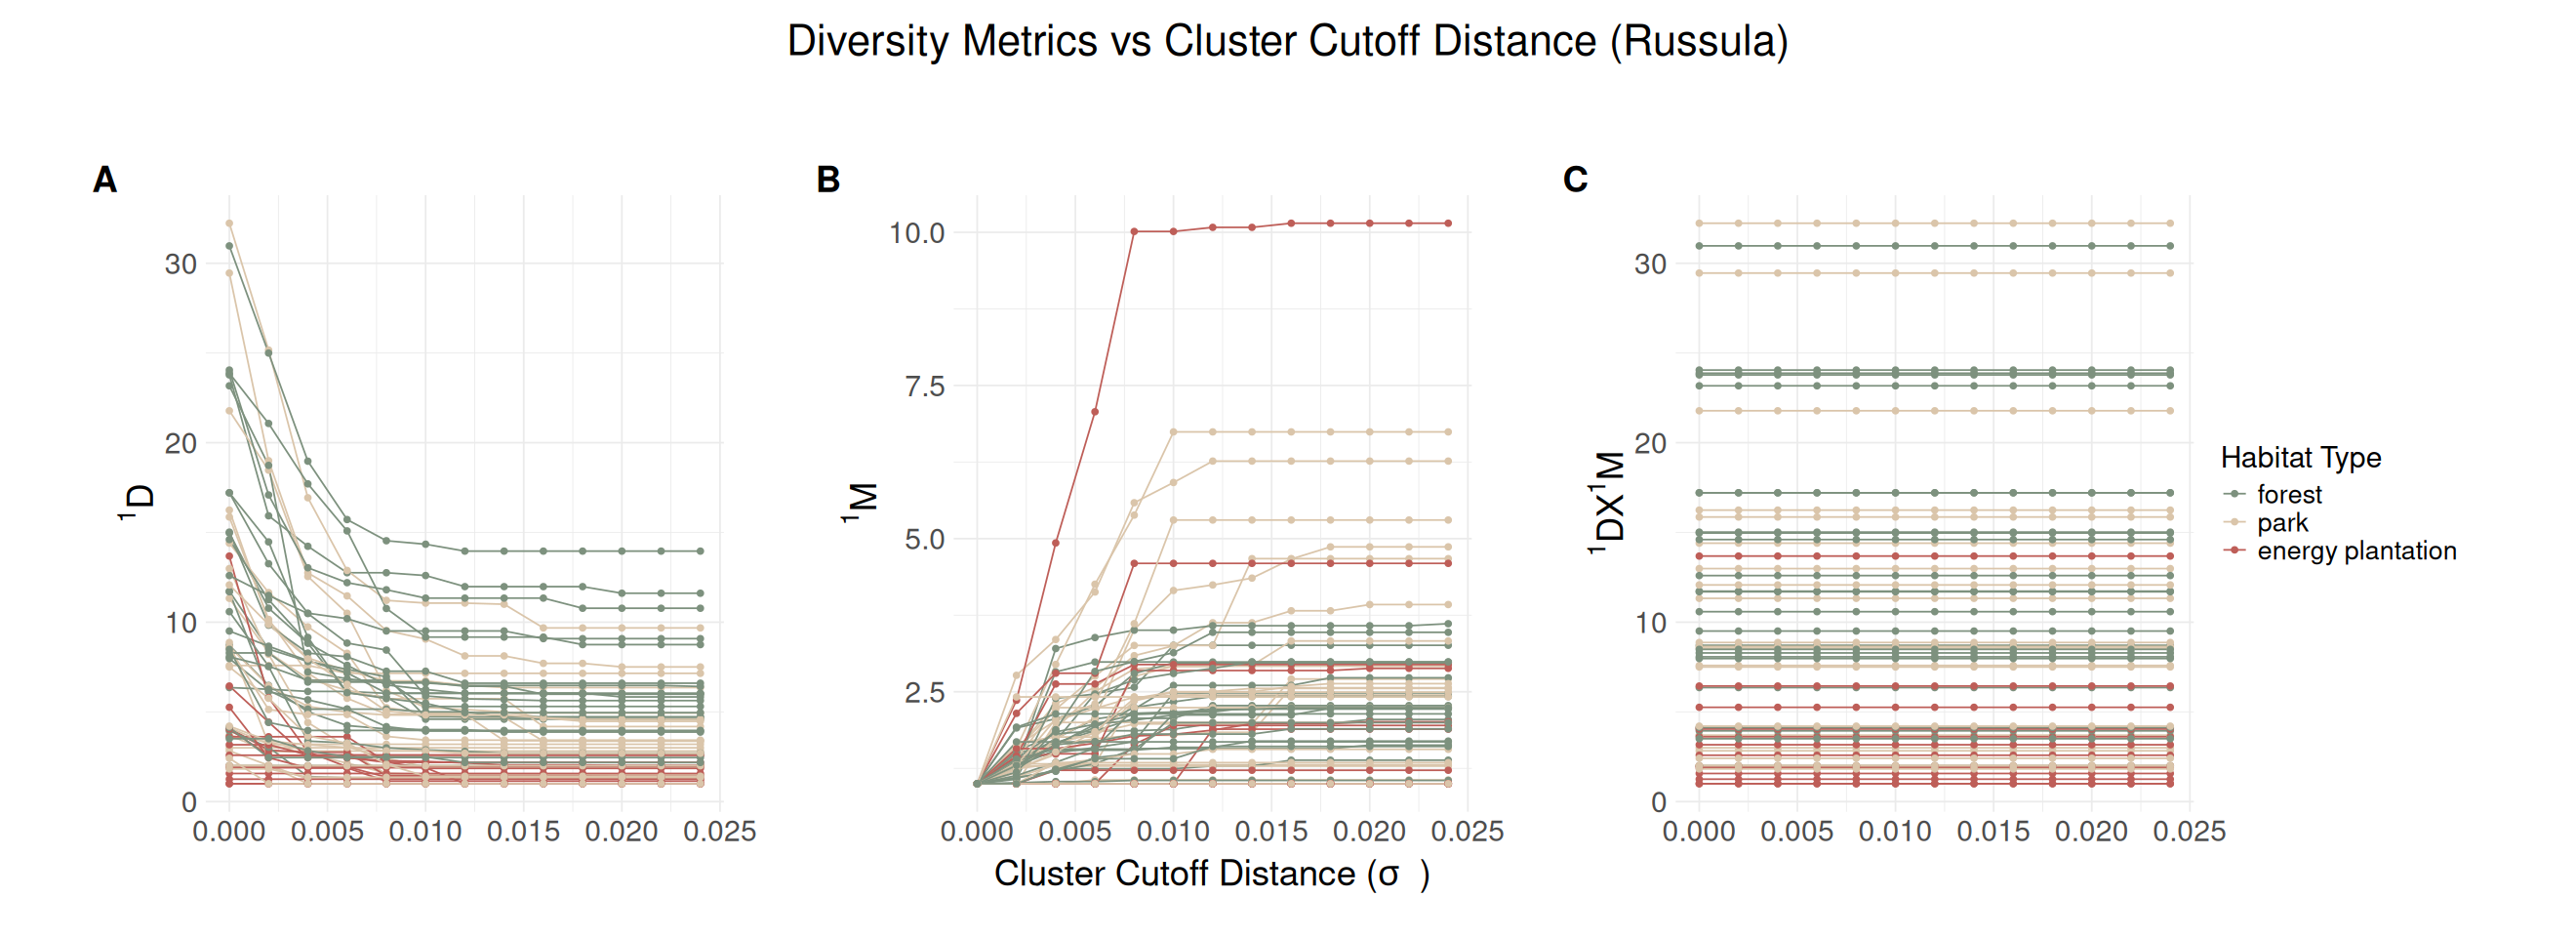

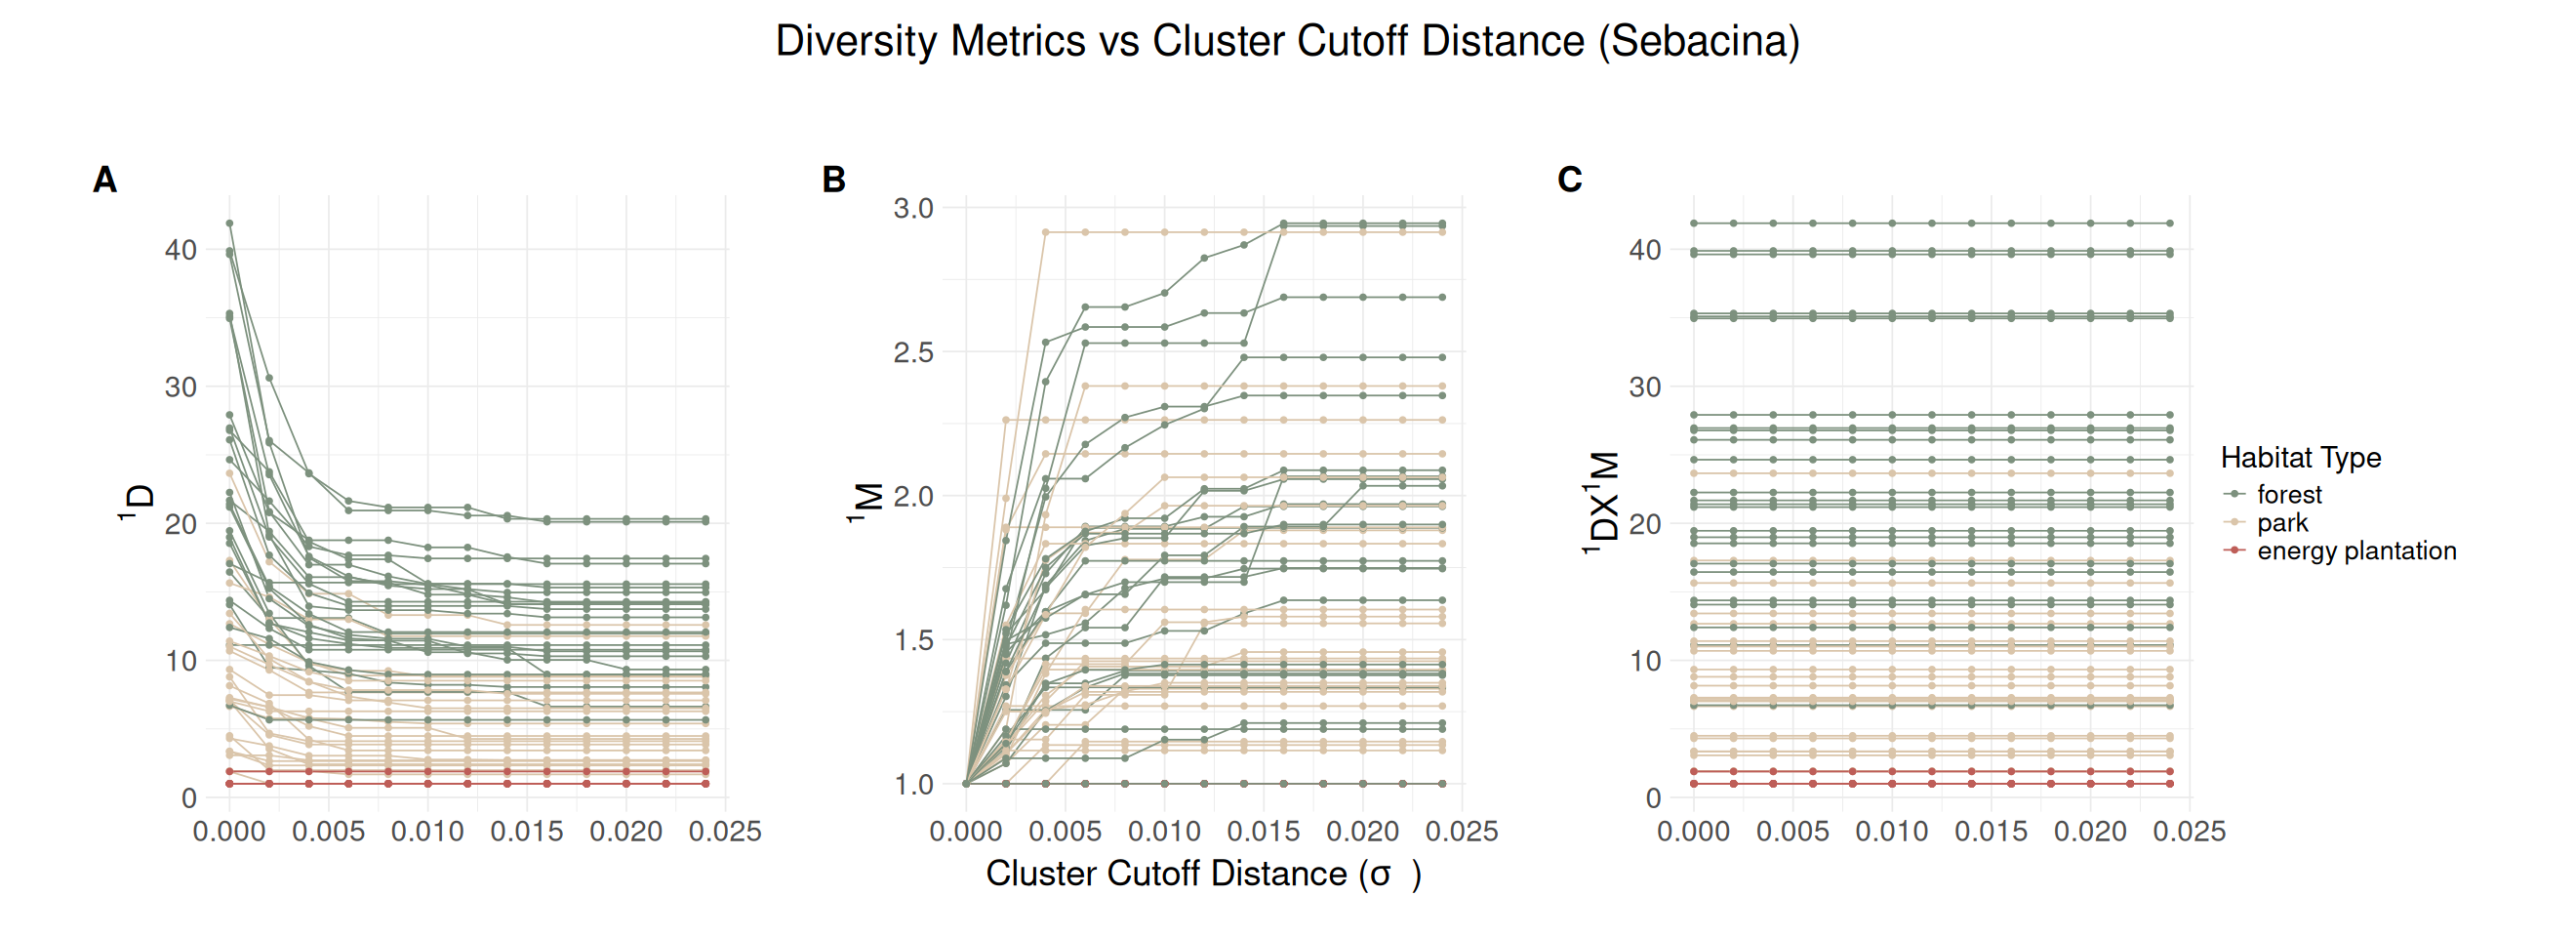

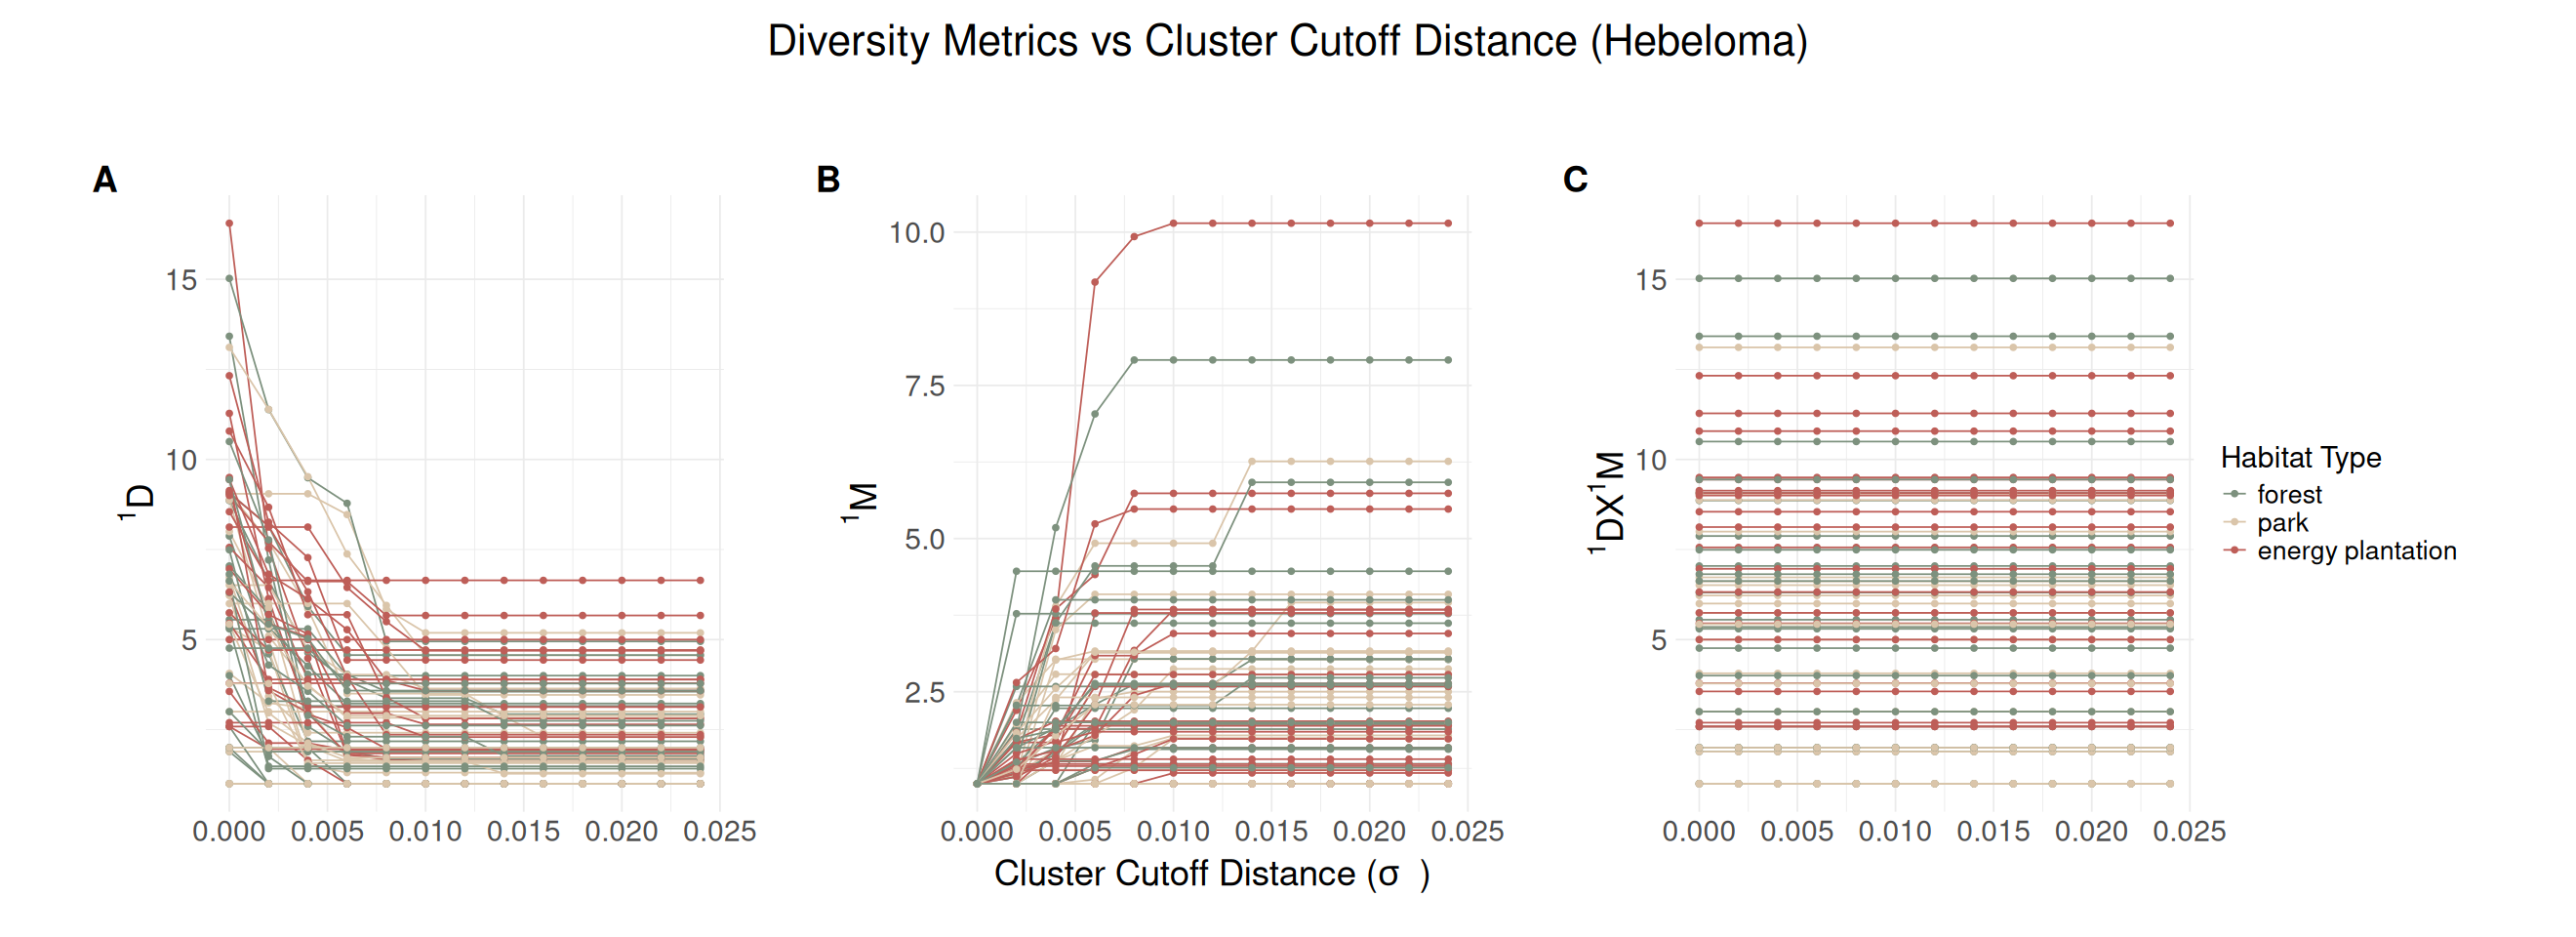

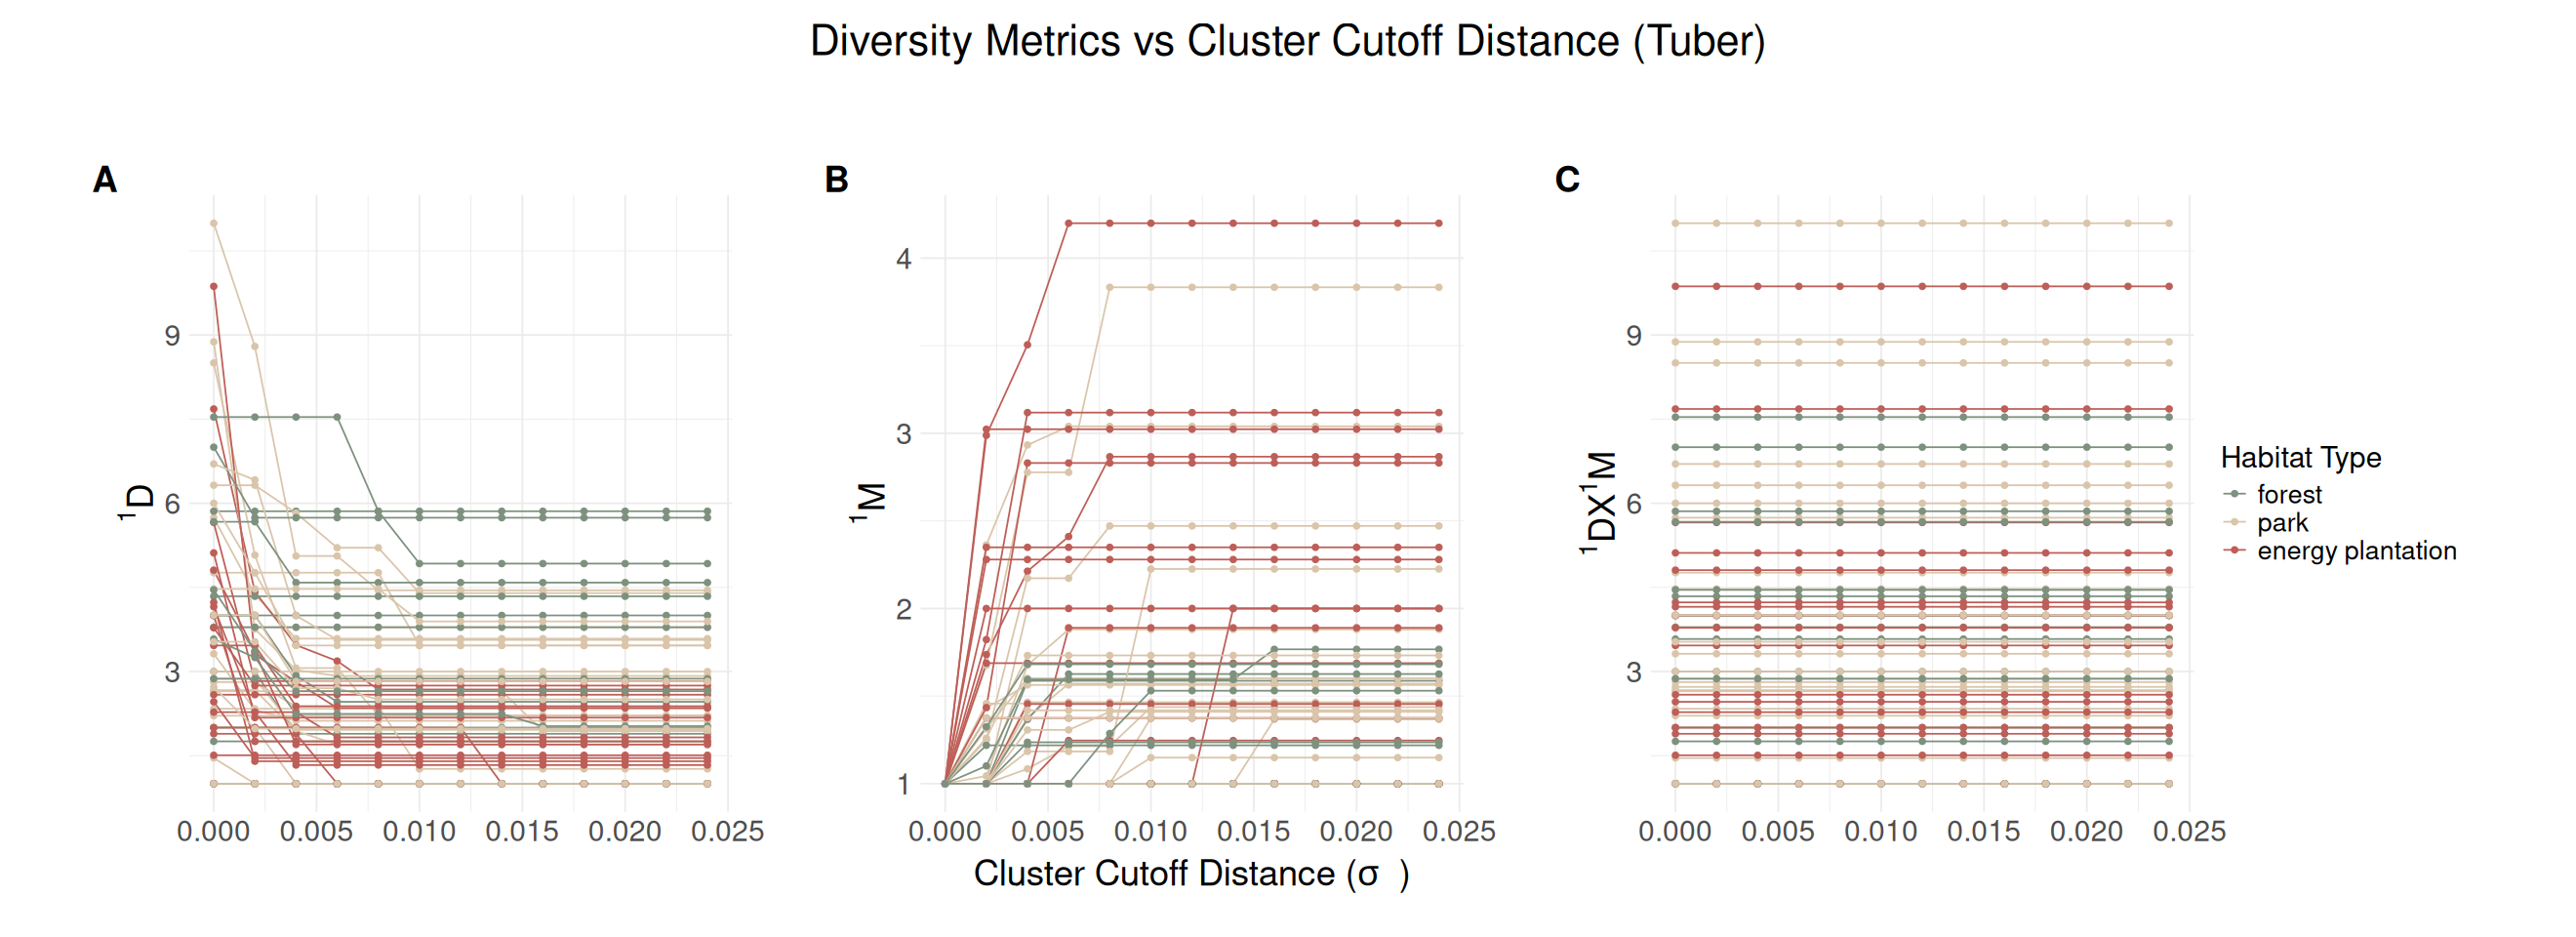

In [22]:
file_name <- "EST-LAT/processed_data/multi_diver_veg.csv"
df <- read_csv(file_name, col_types = cols())    

df_analysis <- df %>%      
        filter(Taxa != "All")  %>% 
        filter(Diversity > 0 ) %>% 
        filter(SampleID != "All")

df_plot <- df_analysis


for(txg in selected_genus)
{

  options(repr.plot.width = 22, repr.plot.height = 8)

  selected_taxa <- txg

  # Define vegetation order and colors
  veg_levels <- c('forest', 'park', 'energy plantation')

    custom_colors <- c('#7D917E',
                    '#DAC5AA',
                    '#BE5E58'
      )



  df <- df_plot %>% 
    filter(Taxa == selected_taxa) %>% 
    filter(Clust_Dist <= 0.025) %>%
    mutate(Vegetation = factor(Vegetation, levels = veg_levels))  # enforce order

  # Common plot style function
  make_plot <- function(y_var, y_label, show_legend = TRUE, show_x_label = FALSE) {
    ggplot(df, aes(x = Clust_Dist, y = .data[[y_var]], color = Vegetation, group = SampleID)) +
      geom_line() +
      geom_point() +
      scale_color_manual(values = custom_colors) +   # apply custom colors
      labs(
        x = if (show_x_label) TeX("Cluster Cutoff Distance ($\\sigma \\;$)") else NULL,
        y = TeX(y_label),
        color = "Habitat Type"

      ) +
      theme_minimal() +
      theme(
        plot.margin = margin(2, 2, 2, 2, "cm"),
        axis.title = element_text(size = 22),
        axis.text = element_text(size = 18),
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 16),
        axis.title.x = element_text(vjust = -0.5),
        legend.position = if (show_legend) "right" else "none"
      )
  }

  # Create plots
  p1 <- make_plot("Diversity", "$^1D$", show_legend = FALSE)
  p2 <- make_plot("Multiplicity", "$^1M$", show_legend = FALSE, show_x_label = TRUE)
  p3 <- make_plot("Cross", "$^1D X ^1M$", show_legend = TRUE)

  # Combine into single row
  final_plot <- p1 + p2 + p3 +
    plot_layout(ncol = 3, guides = "collect") &
    theme(plot.margin = margin(0.5, 1, 0.5, 1, "cm"))

  # Add tags A, B, C + global title
  final_plot <- final_plot + 
    plot_annotation(
      title = TeX(paste0("Diversity Metrics vs Cluster Cutoff Distance (", selected_taxa, ")")),
      tag_levels = 'A'
    ) &
    theme(
      plot.tag = element_text(face = "bold", size = 22),
      plot.title = element_text(size = 26, hjust = 0.5, margin = margin(b = 40))
    )

  # Save combined plot
  ggsave(
    paste0("EST-LAT/results/sigma_plots/", tolower(txg), "_all_samples_three_metrics.png"),
    plot = final_plot,
    width = 22, height = 10, dpi = 400, bg = "white"
  )

  print(final_plot)

}
